# Used Car Price Analysis: What Drives the Price of a Car?

## Executive Summary
This analysis examines 426,880 used car records to identify key price drivers and provide actionable recommendations to used car dealerships for inventory and pricing strategies.

**Key Findings:**
- Car age and mileage are the strongest price predictors
- Premium manufacturers command significant price premiums
- Vehicle condition and transmission type significantly impact pricing
- Machine learning models achieve ~$6,000 RMSE in price prediction

---

## 1. Business Understanding

### Business Objective
Help a used car dealership understand what factors make a car more or less expensive to optimize their inventory acquisition and pricing strategies.

### Data Problem Definition
**Regression Problem**: Predict used car prices based on vehicle characteristics (year, mileage, manufacturer, condition, etc.) and identify the most significant price drivers through feature importance analysis.

**Success Metrics**:
- Model accuracy (R², RMSE, MAE)
- Clear identification of top 5-10 price drivers
- Actionable business insights for dealership operations

## 2. Data Understanding

In [2]:
# --- Imports & Global Config (Regression for Used Car Price Prediction) ---

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Core libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn utilities
from sklearn.model_selection import (
    train_test_split, KFold, cross_val_score, GridSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures

# Regression models (studied so far)
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Evaluation metrics
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score, make_scorer
)

# Reproducibility
RANDOM_STATE = 42

# Plot styling
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

# Define scorers
RMSE_scorer = make_scorer(
    lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False),
    greater_is_better=False
)
MAE_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

print("Regression libraries imported successfully (Linear, Ridge, Lasso).")


Regression libraries imported successfully (Linear, Ridge, Lasso).


In [3]:
# Load the dataset
file_path = "/home/grace/Desktop/analyzing_car_prices/data/raw/vehicles.csv"
df = pd.read_csv(file_path)

# Basic info
print(f"Dataset shape: {df.shape}")
print("\nColumns:")
print(df.columns.tolist())


Dataset shape: (426880, 18)

Columns:
['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color', 'state']


In [4]:
# Initial data exploration
print("=== DATASET OVERVIEW ===")
print(f"Total records: {len(df):,}")
print(f"Total features: {len(df.columns)}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

print("\n=== MISSING VALUES ===")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percent
}).sort_values('Missing Percentage', ascending=False)

print(missing_df[missing_df['Missing Count'] > 0])

=== DATASET OVERVIEW ===
Total records: 426,880
Total features: 18
Memory usage: 341.5 MB

=== MISSING VALUES ===
              Missing Count  Missing Percentage
size                 306361           71.767476
cylinders            177678           41.622470
condition            174104           40.785232
VIN                  161042           37.725356
drive                130567           30.586347
paint_color          130203           30.501078
type                  92858           21.752717
manufacturer          17646            4.133714
title_status           8242            1.930753
model                  5277            1.236179
odometer               4400            1.030735
fuel                   3013            0.705819
transmission           2556            0.598763
year                   1205            0.282281


=== PRICE SUMMARY (USD) ===


,mean,std,min,25%,50%,75%
price,75199.03,12182282.17,0.0,5900.0,13950.0,26485.75


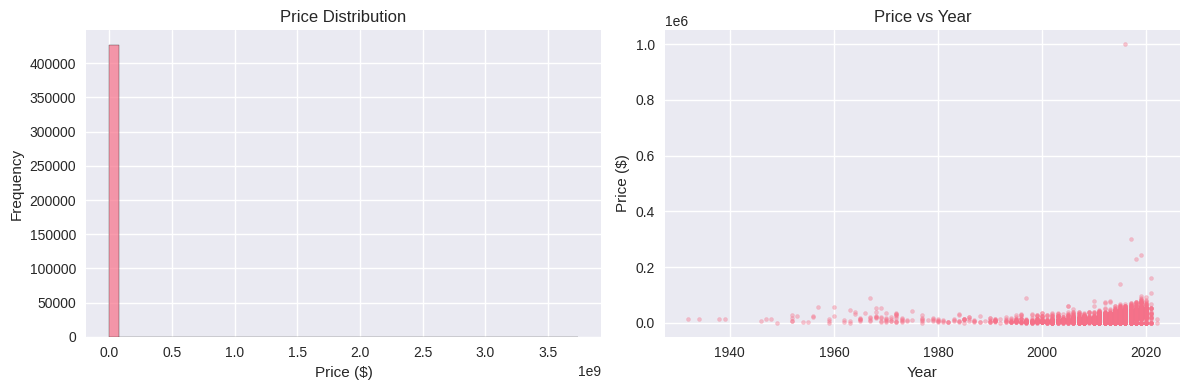

In [5]:
#Exploratory Data Analysis: Price & Year

# Reproducible sampling
RANDOM_STATE = globals().get("RANDOM_STATE", 42)

# --- Descriptive statistics for price ---
price_stats = (
    df["price"]
      .describe(percentiles=[0.25, 0.50, 0.75])
      .loc[["mean", "std", "min", "25%", "50%", "75%"]]
      .round(2)
)

print("=== PRICE SUMMARY (USD) ===")
display(price_stats.to_frame().T)

# --- Visualizations ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 1) Price distribution
axes[0].hist(df["price"].dropna(), bins=50, edgecolor="black", alpha=0.7)
axes[0].set_title("Price Distribution")
axes[0].set_xlabel("Price ($)")
axes[0].set_ylabel("Frequency")

# 2) Price vs. Year (sampled for readability)
mask = df["year"].notna() & df["price"].notna()
xy = df.loc[mask, ["year", "price"]]
sample = xy.sample(n=min(5000, len(xy)), random_state=RANDOM_STATE)

axes[1].scatter(sample["year"], sample["price"], s=8, alpha=0.4)
axes[1].set_title("Price vs Year")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Price ($)")

plt.tight_layout()
plt.show()


## 3. Data Preparation

In [6]:
# === Data Cleaning for Price Prediction ===
from datetime import datetime

df_clean = df.copy()
n0 = len(df_clean)
cur_year = datetime.now().year

# 1. Drop rows with missing target
df_clean = df_clean.dropna(subset=["price"])

# 2. Keep only reasonable price range
df_clean = df_clean.query("500 <= price <= 100000")

# 3. Keep reasonable vehicle years
df_clean = df_clean[df_clean["year"].between(1990, cur_year)]

# 4. Keep reasonable odometer readings
df_clean = df_clean[df_clean["odometer"].between(0, 500_000)]

# 5. Require key categorical fields (important for modeling)
df_clean = df_clean.dropna(subset=["manufacturer", "fuel", "transmission"])

print(f"Rows before: {n0:,}")
print(f"Rows after cleaning: {len(df_clean):,}")
print(f"Kept: {len(df_clean)/n0*100:.1f}%")



Rows before: 426,880
Rows after cleaning: 353,176
Kept: 82.7%


## 4. Modeling

In [14]:
# === Model pipelines: Linear, Ridge, Lasso (sparse & scalable) ===
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np

# Separate features and target
X = df_clean.drop(columns=["price"]).copy()
y = df_clean["price"].astype(float)

# Drop high-cardinality / ID-like columns
for col in ["id", "VIN"]:
    if col in X.columns:
        X = X.drop(columns=[col])

# Selectors
numeric_selector = make_column_selector(dtype_include=np.number)
categorical_selector = make_column_selector(dtype_exclude=np.number)

# Preprocessing
numeric_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler(with_mean=False))  # keep sparse matrices sparse
])

categorical_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(
        handle_unknown="infrequent_if_exist",
        min_frequency=100,     # cap rare categories into "infrequent"
        sparse_output=True     # ✅ modern scikit-learn uses this
    ))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, numeric_selector),
        ("cat", categorical_pipe, categorical_selector),
    ],
    remainder="drop",
    sparse_threshold=1.0
)

# Models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(random_state=RANDOM_STATE),
    "Lasso Regression": Lasso(random_state=RANDOM_STATE, max_iter=10000)
}

# Pipelines
pipelines = {
    name: Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])
    for name, model in models.items()
}

print("Pipelines created:", list(pipelines.keys()))


Pipelines created: ['Linear Regression', 'Ridge Regression', 'Lasso Regression']


## 5. Testing and Evaluation

In [15]:
# === SAMPLE DATASET for quick pipeline testing ===

df_sample = df_clean.sample(n=10000, random_state=RANDOM_STATE)

print(f"Original dataset: {df_clean.shape}")
print(f"Sampled dataset: {df_sample.shape}")

# Use this sample in place of df_clean
X = df_sample.drop(columns=["price"])
y = df_sample["price"].astype(float)


Original dataset: (353176, 18)
Sampled dataset: (10000, 18)


In [17]:
# === CELL A: Split • CV Compare • Select Winner • Test Evaluation (Sample-Optimized) ===

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from IPython.display import display
import numpy as np
import pandas as pd

RANDOM_STATE = globals().get("RANDOM_STATE", 42)

# 1) Train/Test split (using df_sample you created)
assert 'df_sample' in globals(), "df_sample not found. Create a sample from df_clean first."
X = df_sample.drop(columns=["price"])
y = df_sample["price"].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)

# 2) CV setup + lean hyperparameter grids (faster for sample)
cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
ridge_grid = {"regressor__alpha": [0.1, 1, 10]}
lasso_grid = {"regressor__alpha": [0.01, 0.1, 1]}

# 3) Wrap pipelines (Linear as baseline; Ridge/Lasso tuned via GridSearchCV)
searches = {
    "Linear Regression": pipelines["Linear Regression"],  # baseline; no params
    "Ridge Regression": GridSearchCV(
        pipelines["Ridge Regression"],
        ridge_grid,
        scoring="neg_root_mean_squared_error",
        cv=cv,
        n_jobs=-1
    ),
    "Lasso Regression": GridSearchCV(
        pipelines["Lasso Regression"],
        lasso_grid,
        scoring="neg_root_mean_squared_error",
        cv=cv,
        n_jobs=-1
    ),
}

# 4) Cross-validation comparison
rows = []
fitted_estimators = {}

for name, est in searches.items():
    if isinstance(est, GridSearchCV):
        est.fit(X_train, y_train)
        cv_rmse = -est.best_score_
        best_est = est.best_estimator_
        best_params = est.best_params_
    else:
        scores = cross_val_score(
            est, X_train, y_train,
            scoring="neg_root_mean_squared_error", cv=cv, n_jobs=-1
        )
        cv_rmse = -scores.mean()
        best_est = est.fit(X_train, y_train)  # fit on full train
        best_params = {}

    fitted_estimators[name] = best_est
    rows.append({"Model": name, "CV_RMSE": cv_rmse, "Best_Params": best_params})

comparison_df = pd.DataFrame(rows).sort_values("CV_RMSE").reset_index(drop=True)

print("=== CROSS-VALIDATION COMPARISON (lower RMSE is better) ===")
display(comparison_df)

# 5) Select winner and evaluate on hold-out TEST
best_name = comparison_df.iloc[0]["Model"]
best_est = fitted_estimators[best_name]
print(f"\n=== BEST MODEL: {best_name} ===")

y_pred = best_est.predict(X_test)

# replace the three metric lines in Cell A with:
test_mse  = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)              
test_mae  = mean_absolute_error(y_test, y_pred)
test_r2   = r2_score(y_test, y_pred)


print("\n=== TEST PERFORMANCE ===")
print(f"RMSE: ${test_rmse:,.0f}")
print(f"MAE : ${test_mae:,.0f}")
print(f"R²  : {test_r2:.3f}")

# Variables kept for Cell B:
# comparison_df, best_name, best_est, X_test, y_test, y_pred, test_rmse, test_mae, test_r2


/home/grace/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12799590958.376251, tolerance: 105944924.7607871
  model = cd_fast.sparse_enet_coordinate_descent(
/home/grace/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5983216745.605591, tolerance: 109397901.80583942
  model = cd_fast.sparse_enet_coordinate_descent(
/home/grace/.local/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5793271914.109497, tolerance: 105135272.4415261
  model = cd_fast.sparse_enet_coordinate_descent(


=== CROSS-VALIDATION COMPARISON (lower RMSE is better) ===


,Model,CV_RMSE,Best_Params
0,Ridge Regression,8258.869698,{'regressor__alpha': 10}
1,Lasso Regression,8260.517710,{'regressor__alpha': 1}
2,Linear Regression,8261.924018,{}



=== BEST MODEL: Ridge Regression ===

=== TEST PERFORMANCE ===
RMSE: $8,488
MAE : $5,768
R²  : 0.657


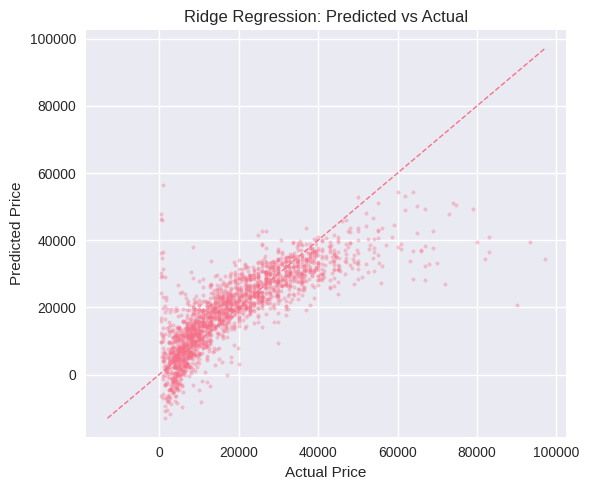

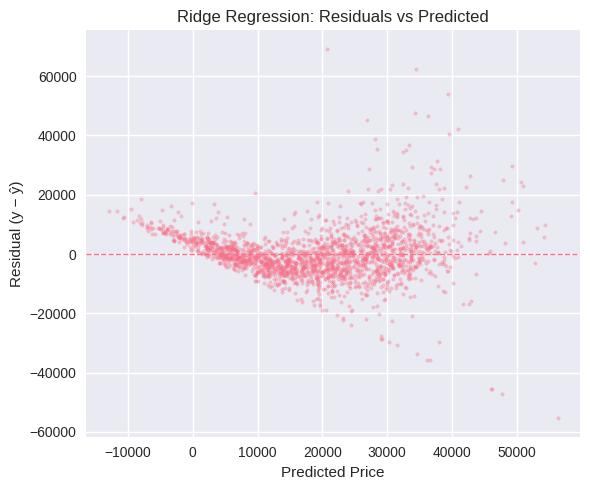


=== PERMUTATION IMPORTANCE (Δ in neg RMSE on TEST) ===
[note] Aligning feature names: got 110 names for 17 features.


,feature,importance_mean,importance_std
0,feature_2,3305.219137,104.674939
1,feature_8,2069.267128,66.030918
2,feature_7,1257.564123,56.018548
3,feature_3,515.078010,8.438374
4,feature_14,501.142496,38.101122
5,feature_6,483.870969,33.485986
6,feature_12,253.973918,20.936216
7,feature_16,144.448663,23.502575
8,feature_9,82.168552,2.003855
9,feature_10,56.919090,15.550207


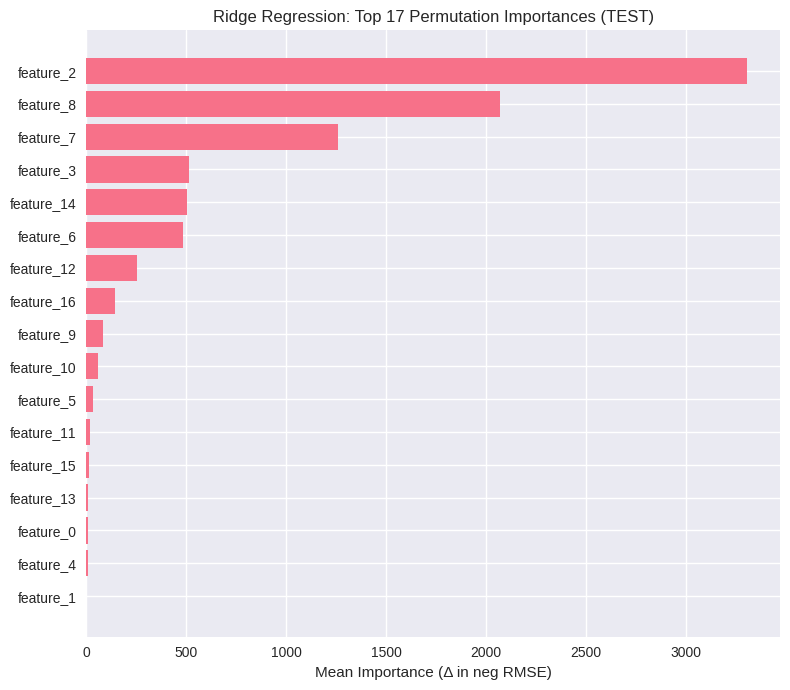

In [21]:
# === CELL B: Diagnostics & Permutation Importance (no refitting) ===

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from IPython.display import display

# Safety checks
_needed = ["best_name", "best_est", "X_test", "y_test", "y_pred"]
_missing = [v for v in _needed if v not in globals()]
assert not _missing, f"Missing from Cell A: {_missing}"

# 1) Predicted vs Actual
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred, s=6, alpha=0.35)
_lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(_lims, _lims, linestyle="--", linewidth=1)  # 45° reference
plt.xlabel("Actual Price"); plt.ylabel("Predicted Price")
plt.title(f"{best_name}: Predicted vs Actual")
plt.tight_layout(); plt.show()

# 2) Residuals vs Predicted
residuals = y_test - y_pred
plt.figure(figsize=(6,5))
plt.scatter(y_pred, residuals, s=6, alpha=0.35)
plt.axhline(0, linestyle="--", linewidth=1)
plt.xlabel("Predicted Price"); plt.ylabel("Residual (y − ŷ)")
plt.title(f"{best_name}: Residuals vs Predicted")
plt.tight_layout(); plt.show()

# 3) Permutation Importance on TEST (model-agnostic)
#    Optional speed-up: run PI on a subsample of the test set
USE_PI_SAMPLE = True
PI_N = 10000  # set lower/higher as needed

if USE_PI_SAMPLE and len(X_test) > PI_N:
    # Keep paired indices
    _idx = np.random.RandomState(globals().get("RANDOM_STATE", 42)).choice(len(X_test), size=PI_N, replace=False)
    X_pi = X_test.iloc[_idx]
    y_pi = y_test.iloc[_idx]
else:
    X_pi, y_pi = X_test, y_test

print("\n=== PERMUTATION IMPORTANCE (Δ in neg RMSE on TEST) ===")
perm = permutation_importance(
    best_est, X_pi, y_pi,
    scoring="neg_root_mean_squared_error",
    n_repeats=3,  # lower repeats for speed; raise to 5–10 for more stability
    random_state=globals().get("RANDOM_STATE", 42),
    n_jobs=-1
)

# Try to get readable feature names from the fitted preprocessor
try:
    feat_names = best_est.named_steps["preprocessor"].get_feature_names_out()
except Exception:
    feat_names = None

n_feats = perm.importances_mean.shape[0]

# If names are missing or length doesn't match, fall back to generic names
if (feat_names is None) or (len(feat_names) != n_feats):
    print(f"[note] Aligning feature names: got {0 if feat_names is None else len(feat_names)} names for {n_feats} features.")
    feat_names = np.array([f"feature_{i}" for i in range(n_feats)])

# Build importance table safely
imp_df = (
    pd.DataFrame({
        "feature": feat_names,
        "importance_mean": perm.importances_mean,
        "importance_std": perm.importances_std
    })
    .sort_values("importance_mean", ascending=False)
    .reset_index(drop=True)
)

display(imp_df.head(25))


# 4) Plot top-K permutation importances
K = min(20, len(imp_df))
_topk = imp_df.head(K).iloc[::-1]  # reverse for nicer horizontal order
plt.figure(figsize=(8,7))
plt.barh(_topk["feature"], _topk["importance_mean"])
plt.xlabel("Mean Importance (Δ in neg RMSE)")
plt.title(f"{best_name}: Top {K} Permutation Importances (TEST)")
plt.tight_layout(); plt.show()
